| Full Name      | Matriculation Number   | Contribution |
|----------------|------------------------|--------------|
|  Sim Oi Liang  |        U2123863L       |     100%     |

### Donwload Libraries and **Dependencies**

In [ ]:
## Install Dependencies 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

In [1]:
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 34.8 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0


### Import Libraries and Helper Functions

In [12]:
# Some Helper Function

import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [13]:
env = gym.make("CartPole-v1")

# Task 1: Development of an RL agent

### RL agent here will be using First Morte Carlo Algorithm to train

<p>The First MC used here is using discrete data instead of continous data.</p>
<p>As all the observation data are all continuous data, so the first task should be changing continous data to discrete data</p>
<p>Method used here is to limit some ranges for the data and transform it into discrete representation. </p>
<p>All the observation space datas will follow the same discrete format but different ranges</p>
<p>Typically, all the data will be transform to discrete values in the array of [0,-1,1,-2,2] where:</p>
<p>(0) = ideal condition</p>
<p>(-1) = close to ideal condition and in negative manners</p>
<p>(1) = close to ideal condition and in positive manners</p>
<p>(-2) = close to terminate condition and in negative manners</p>
<p>(2) = close to terminate condition and in positive manners</p>

<p>Also, each observation data will has Lower and Upper limit and each Lower and Upper limit will has positive and negative value</p>
<p>(0) = between (+) Lower and (-) Lower </p>
<p>(-1) = between (-) Upper and (-) Lower </p>
<p>(1) = between (+) Lower and (+) Upper</p>
<p>(-2) = less than (-) Upper</p>
<p>(2) = more than (+) Upper</p>



<p>The states limit is changed depends on the 1 episode simulated later in Task 3</p>
<p>Generally, if the lineplot of an observation has a y-range where the line is stable, then lower limit will be set to number of the upper limit of this y-range </p>
<p>Same for upper limit, if there is a second y-range where the line is stable, then upper limit will be set to number of the upper limit of this y-range </p>

<p> Details will be cover later in Task 3 <p/>

In [2]:
def cartPosition(ob):
  lower =2
  upper =2.4
  if(ob>=-lower and ob <=lower):
    return 0
  if(ob>lower and ob<=upper):
    return 1
  if(ob>= -upper and ob<-lower):
    return -1
  if(ob>upper):
    return 2
  if(ob<-upper):
    return -2

<p>For Cart Position:</p>
<p>Lower Limit = 2 and Upper limit is 2.4, because terminate value is +-2.4, but if set lower limit to lower than 2, the result will be unstable for other 3 observations</p>

In [3]:
def cartVelocity(ob):
  lower =0.15  
  upper =0.3
  if(ob>=-lower and ob <=lower):
    return 0
  if(ob>lower and ob<=upper):
    return 1
  if(ob>= -upper and ob<-lower):
    return -1
  if(ob>upper):
    return 2
  if(ob<-upper):
    return -2

<p>For Cart Velocity:</p>
<p>Lower Limit = 0.15 and Upper limit is 0.3, the limits are actually tested a few times, the upper and lower limit is set based on the lineplots of Task 3</p>
<p>Basically, if the test result showing the cart move too fast and cause pole fall, then I will lower the limits to make sure the agent can detect the (close to terminate) state more earlier thus avoid going too fast</p>

In [4]:
def poleAngle(ob):
  lower = 0.002412236
  upper = 0.008
  if(ob>=-lower and  ob <=lower):
    return 0
  if(ob>lower and ob <=upper):
    return 1
  if(ob>= -upper and ob<-lower):
    return -1
  if(ob>upper):
    return 2
  if(ob<-upper):
    return -2

<p>For Pole Angle:</p>
<p>Lower Limit = 0.002 rad and Upper limit is 0.08 rad, because the whole experiment is to avoid the pole falling down, thus setting the limits to be as low as possible might the suitable</p>
<p>However, setting limits too low will make the agent unable to explore the (close to fall) state which is (+- 0.2), as (+-0.2) has the same value as (+-upper limit) if upper limit too low, which will induce the agent to treat both states as the same state but (+-0.2) is actually more critical than (+-upper limit). </p>
<p>But still, we are trying to keep the angle to be close to 0 as much as possible, thus setting low will be more suitable.</p>
<p>The limits are also tested a few times, where these limits are good enough for the agent to react rationally.</p>

In [5]:
def angleVelocity(ob):
  lower = 0.1
  upper = 0.3
  if(ob>=-lower and ob <=lower):
    return 0
  if(ob>lower and ob<=upper):
    return 1
  if(ob>= -upper and ob<-lower):
    return -1
  if(ob>upper):
    return 2
  if(ob<-upper): 
    return -2

<p>For Angle Velocity:</p>
<p>Lower Limit = 0.1 rad and Upper limit is 0.3 rad, Angle Velocity changes the most in each action, and the values observed can be as high as +-1 rad to as low as +-0.01 rad and is not consistent, thus this limits are set based on the Task 3 lineplot results also.</p>

In [6]:
def transform(ob_list):
  # cart position, velocity and pole angle, angular velocity.
  ob_t = []
  ob_t.append(cartPosition(ob_list[0]))
  ob_t.append(cartVelocity(ob_list[1]))
  ob_t.append(poleAngle(ob_list[2]))
  ob_t.append(angleVelocity(ob_list[3]))
  return ob_t

<p>Transform function:</p>
<p>This function is just used for transforming the continous data to discret using all the functions/limits above</p>

In [7]:
def get_state_index(ob_list):
  five_input = [-1,0,1,2,-2]
  total = 5*5*5*5
  ob_Value = [5,5,5,5]
  p_i =0

  for i in range(len(ob_list)):
    total = total/ob_Value[i]   
    times = five_input.index(ob_list[i])  
    p_i += times * total 
    # repeat

  return int(p_i)

<p>get_state_index(ob_list):</p>
<p>This function is just used to get the index number for each possible state, which in this case is 625 states as each observation data has 5 possible discrete values [0,-1,1,-2,2]</p>
<p>So total is 5*5*5*5 = 625 posible number of states</p>

In [10]:
def reward_exp(S, A, S_Prime): 
  # cart position, velocity and pole angle, angular velocity. 

  # pole angle
  i = 2
  # pole angle change fast to right, but action still to left
  if(S_Prime[i] == 2 and S[i] == 2 and A == 0):
    return -2

  # pole angle change fast to left, but action still to right
  if(S_Prime[i] == -2 and S[i] == -2 and A == 1):
    return -2
  
  # pole angle at right change to more right, with action to left
  if(S_Prime[i] == 2 and S[i] == 1 and A ==0 ):
    return -1

  # pole angle at left change to more left, with action to right
  if(S_Prime[i] == -2 and S[i] == -1 and A ==1):
    return -1

  # velocity
  i=1
  # cart moving fast to right, but action still to right
  if(S_Prime[i] == 2 and S[i] == 2 and A ==1 ):
    return -1

  # cart moving fast to left, but action still to left
  if(S_Prime[i] == -2 and S[i] == -2 and A ==0 ):
    return -1

  # cart moving right increase speed to right, with action still to right (encourage cart stay in middle)
  if(S_Prime[i] == 2 and S[i] == 1 and A ==1 ):
    return 1

  # cart moving left increase speed to left, with action still to right (encourage cart stay in middle)
  if(S_Prime[i] == -2 and S[i] == -1 and A ==0 ):
    return 1  
    
  return 2


<p>reward_exp(S, A, S_Prime):</p>
<p>This function is used to set rewards for each state and action</p>
<p>All the actions taken will has a reward of 2</p>
<p>Some explicit action:</p>
<p>Pole Angle:<br> - basically the agent need to prioritise setting the pole upstright before anything else, thus if the previsous state and current state both in (close to terminate state) and action also favor (terminate state), then the agent need correct it immediately, thus reward will be -2. A (-1) reward will be return if state changes from (close to ideal state) to (close to terminate state) to encourage agent to balance the pole angle to ideal state as long as possible.</p>
<p>Cart Velocity: Reward returned will be lesser if agent keeps increasing the speed of the cart. High speed cart will cause the pole to be unstable, even after the the pole change from (close to terminate state) to (ideal state), it will immedietely change back to (close to terminate state) if speed of cart is too high.
<p>Generally, return reward of pole angle should be lower than speed, so that agent will priotize setting pole angle straight up first</p>

In [14]:
import random
Q = []
Policy =  []
Returns = []
state_num = 5*5*5*5
cul_r =[]
for i in range(state_num):
  Q.append([])
  Returns.append([])

  prob = random.random()
  Policy.append([prob, (1-prob)])

  for j in range(2):
    # 2 actions
    Q[i].append(random.random())

    # entries store a list
    Returns[i].append([])

    
episodes = 500
for a in range(episodes):
    step =0
    observation = env.reset()
    state = transform(observation)
    cumulative_reward = 0
    ob_list = [state]
    action_list = []
    exp_reward = []
    prev_ob = state
    done = False
    while not (done or step ==500):
        step+=1

        # choice follow probability
        action = random.choices([0,1], weights = (Policy[get_state_index(prev_ob)][0],\
                                                Policy[get_state_index(prev_ob)][1]), k=1)[0]
        observation, reward, done, info = env.step(action)
        state = transform(observation)
        cumulative_reward += reward

        ob_list.append(state)
        action_list.append(action)
        r = reward_exp(prev_ob, action, state)
        exp_reward.append(r)
        prev_ob = state
  
    cul_r.append(cumulative_reward)


    state_visited = []
    # last ob dont have any action thus ignore
    for b in range(len(ob_list)-1):

        if ob_list[b] in state_visited:
              continue

        state_visited.append(ob_list[b])

        R = 0
        gamma =1
        for c in range(b , len(exp_reward)):
            R += gamma*exp_reward[c]
            gamma = gamma*0.99

        state_index = get_state_index(ob_list[b])
        Returns[state_index][action_list[b]].append(R)

    for d in range(state_num):
        for e in range(2):
            R_list = Returns[d][e]
            if len(R_list) ==0:
                continue

            sum=0
            for k in range(len(R_list)):
                sum += R_list[k]

            Q[d][e] = sum/len(R_list)


    for f in range(len(Q)):
        max = -99999
        AC= 0
        for g in range(2):
            if Q[f][g] > max:
                max = Q[f][g]
                AC = g

        # prob for exploration
        epsilon =0.1
        AF =1
        if AC == 1:
            AF =0
            
        Policy[f][AC] = 1 - epsilon + epsilon/2
        Policy[f][AF] = epsilon/2

<p>This function is an implementation of first MC algorithm.</p>
<p>1) Initialize Q(s,a), Returns[][], and Random Policy Value</p>
<p>2) This method uses discount rate = 0.99 and epsilon rate = 0.1 to encourage exploration</p>
<p> 3) Each action will induce a virtual reward of 2, some explicit state-action will have lesser virtual reward for better traning result </p>
<p>4) This algorithm is run for 500 episodes for traning, and traning results (real culmulative reward) will be recorded in the array cul_r for every episodes</p>

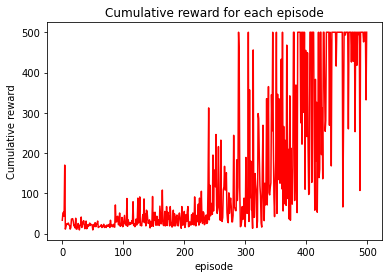

In [16]:
plt.figure()
plt.plot(range(len(cul_r)), cul_r, 'r')
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

<p>This shows the traning results in terms of cumulative reward for each episodes</p>
<p>We can see that the result generally get better for later episodes but highly inconsistant, mainly because setting continous data to discrete data within some ranges will cause the agent unable to explore all the continous observations, thus creating inconsistancy in every episodes. And also encouraging exploration will also cause traing result to be unstable. </p>

In [15]:
def rand_policy_agent(observation):
  state = transform(observation)
  AC = 0
  if Policy[get_state_index(state)][1] > Policy[get_state_index(state)][0]:
    AC =1
  return AC

<p>This function is used to get the highest probability of the two actions in each states and return the higher probability action</p>

# Task 2: Simulate 100 episodes


In [17]:
cul_r=[]
for i in range(100):
  cumulative_reward = 0
  observation = env.reset()
  while True:
      action = rand_policy_agent(observation)
      observation, reward, done, info = env.step(action) 
      cumulative_reward += reward
      if done: 
        break; 
  cul_r.append(cumulative_reward)

<p>This is used to simulate/testing for 100 episodes</p>

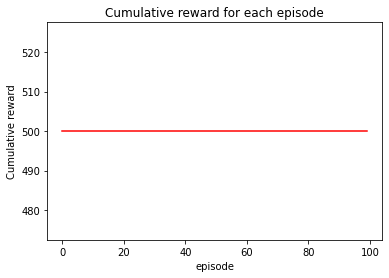

In [18]:
plt.figure()
plt.plot(range(len(cul_r)), cul_r, 'r')
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

<p>This is the result of 100 episodes, we can see for each episodes, the agent mostly are able to stay for 500 steps </p>


In [19]:
sum=0
for k in range(len(cul_r)):
  sum += cul_r[k]
mean = sum/len(cul_r)
print("Average cumulative reward:", mean)
print("Is my agent good enough?", mean > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


# Task 3: Simulate 1 episode with video



In [20]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
cumulative_reward = 0
state = transform(observation)
states=[state]
ob =[observation]
actions =[]


while True:
    env.render()
    #your agent goes here
    action = rand_policy_agent(observation)
    actions.append(action)
    observation, reward, done, info = env.step(action) 
    ob.append(observation)
    state = transform(observation)
    cumulative_reward += reward
    state = transform(observation)
    states.append(state)
    if done: 
      break;    
env.close()
print("Cumulative reward for this round:", cumulative_reward)


Cumulative reward for this round: 500.0


<p> Video cannot be show here for some unknown reason (might be some bug), but the video is shown in the Google Colabs session storage, so the video will be attached together with this report</p>

In [21]:
import seaborn as sb
import pandas as pd

# create pandas df for observations(numpy matrix array)
frame = ob
numpy_data= np.array(frame)
df = pd.DataFrame(data=numpy_data)
df.columns = [f'mycol{i}' for i in range(0,len(df.T))] 

# create pandas df for states(numpy matrix array)
frame = states
numpy_data= np.array(frame)
df2 = pd.DataFrame(data=numpy_data)
df2.columns = [f'mycol{i}' for i in range(0,len(df2.T))] 

# create pandas df for actions(numpy matrix array)
frame = actions
numpy_data= np.array(frame)
df3 = pd.DataFrame(data=numpy_data)
df3.columns = [f'mycol{i}' for i in range(0,len(df3.T))] 

<Axes: title={'center': 'Pole Velocity'}, xlabel='Steps', ylabel='Pole Velocity State'>

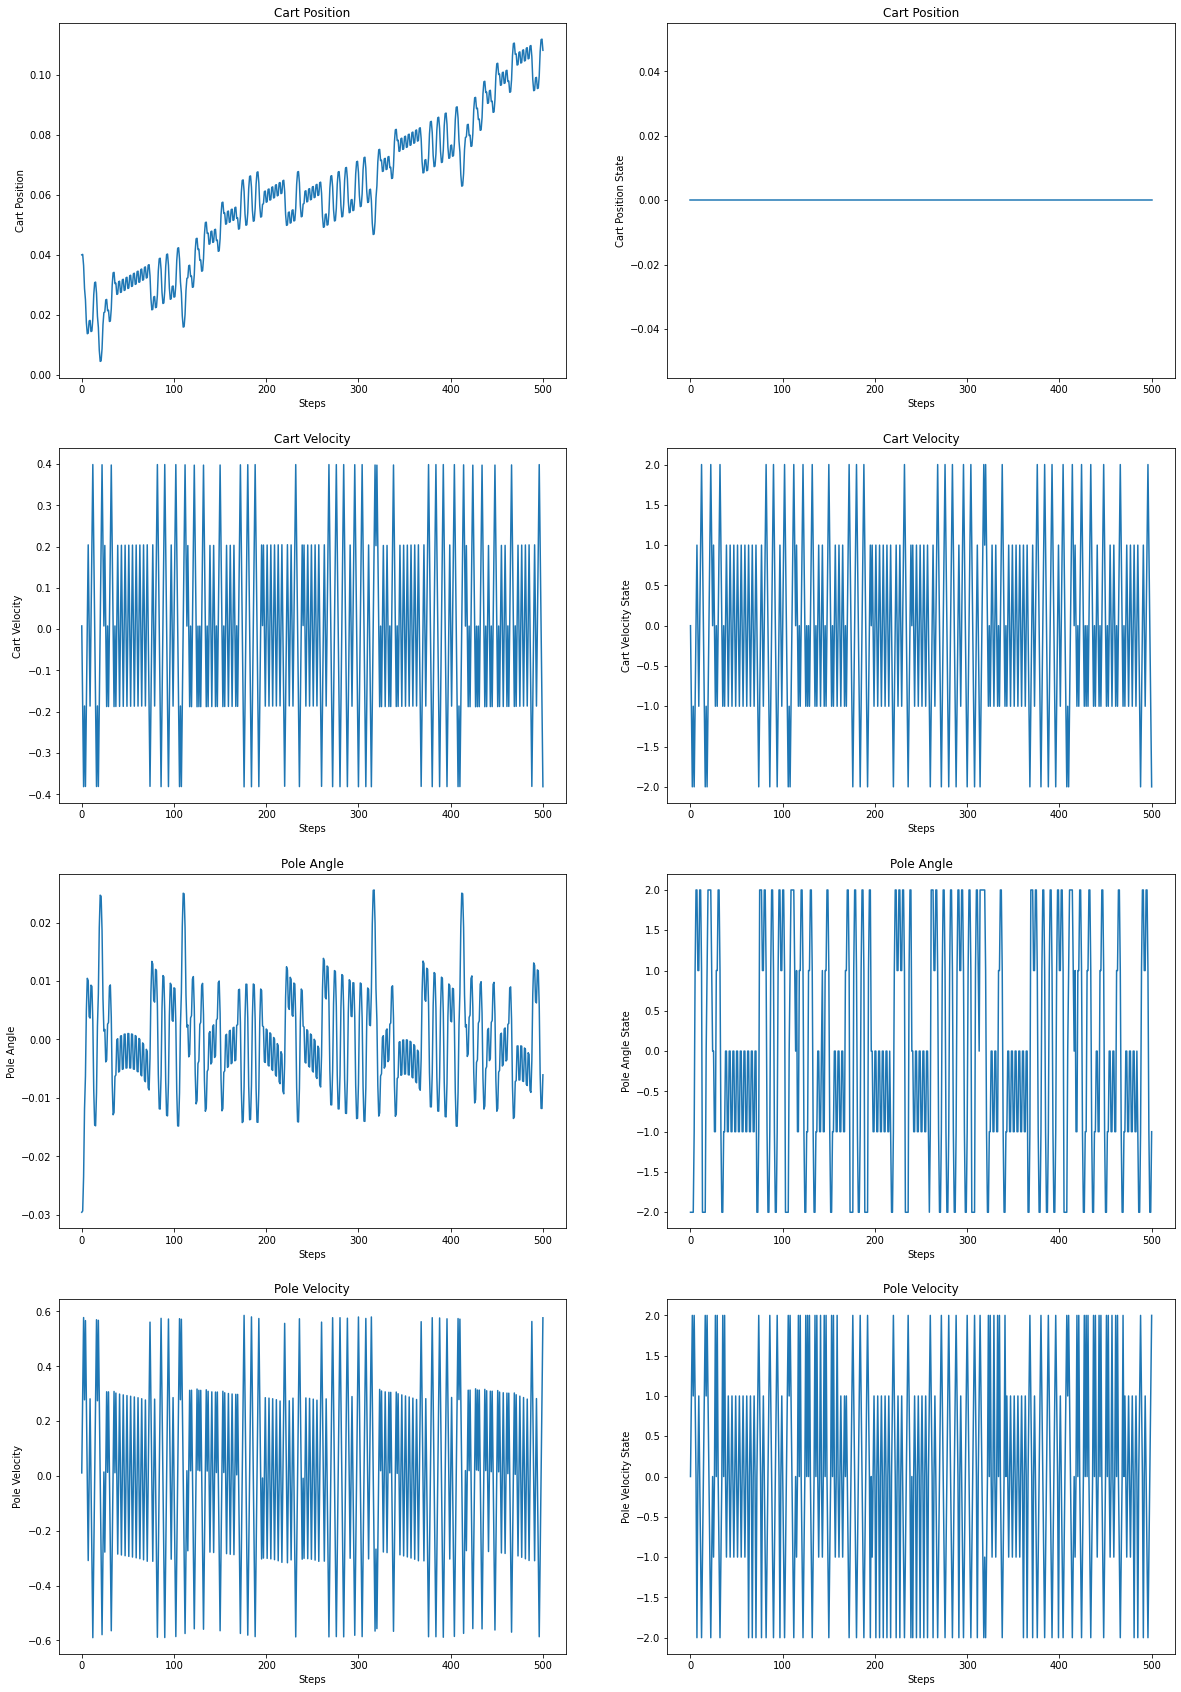

In [24]:
# Set up matplotlib figure with 8 subplots (4row x 2col)
f, axes = plt.subplots(4, 2, figsize=(20, 30))
axes[0,0].set(xlabel = "Steps", ylabel="Cart Position",title="Cart Position")
axes[1,0].set(xlabel = "Steps", ylabel="Cart Velocity",title="Cart Velocity")
axes[2,0].set(xlabel = "Steps", ylabel="Pole Angle",title="Pole Angle")
axes[3,0].set(xlabel = "Steps", ylabel="Pole Velocity",title="Pole Velocity")

axes[0,1].set(xlabel = "Steps", ylabel="Cart Position State",title="Cart Position")
axes[1,1].set(xlabel = "Steps", ylabel="Cart Velocity State",title="Cart Velocity")
axes[2,1].set(xlabel = "Steps", ylabel="Pole Angle State",title="Pole Angle")
axes[3,1].set(xlabel = "Steps", ylabel="Pole Velocity State",title="Pole Velocity")

# Cart Post observation
sb.lineplot( data = df['mycol0'], ax = axes[0,0])
sb.lineplot( data = df2['mycol0'], ax = axes[0,1])

# Cart Velocity observation
sb.lineplot( data = df['mycol1'], ax = axes[1,0])
sb.lineplot(data = df2['mycol1'], ax = axes[1,1])

# Pole Angle observation
sb.lineplot(data = df['mycol2'], ax = axes[2,0])
sb.lineplot(data = df2['mycol2'], ax = axes[2,1])

# Angular Velocity observation
sb.lineplot(data = df['mycol3'], ax = axes[3,0])
sb.lineplot(data = df2['mycol3'], ax = axes[3,1])

<p> The result is plotted for the purpose of observing and chnaging the state limit for each observation</p>

<p> For example, for cart velocity, we can see that there is a range of value in y-axis where the line is stable (ie the range if about [0.2 to -0.2]), so the lower state limit will set to 0.2 for cart velocity<p>

<p> As for the upper limit, we can see that the highest limit is about 0.4, so upper state limit will set to 0.4</p>

<p> Different episode will be different in result, so the Task 3 is repeated a few times to obtain a stable result for all observations to set the limit, except for cart position, as it do not has any stable range, so the state limit is set randomly such that the limit will not affect much to other 3 observation results should be fine </p>